Frecuencia más cercana a 0 dB en T2: 12.56 Mrad/s  → 0.01 dB, fase 65.2°
Frecuencia más cercana a 65° en T2:  12.68 Mrad/s  → 65.0°


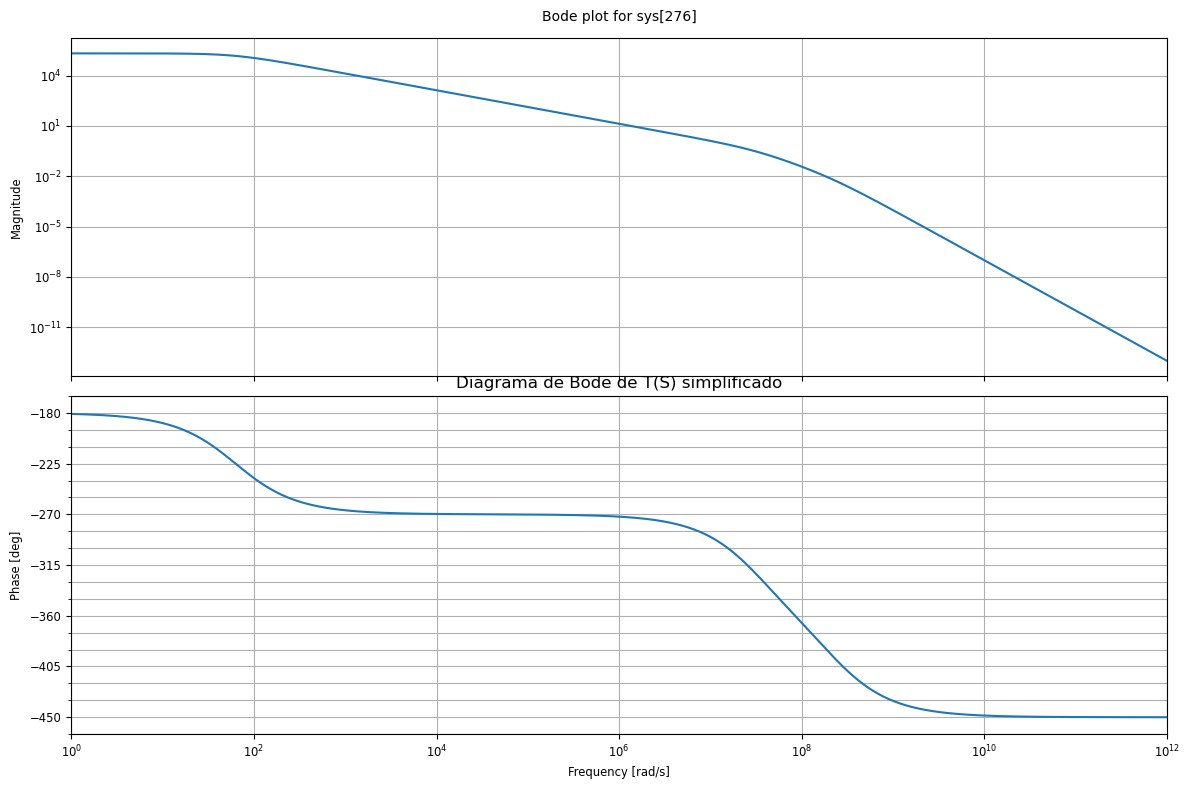

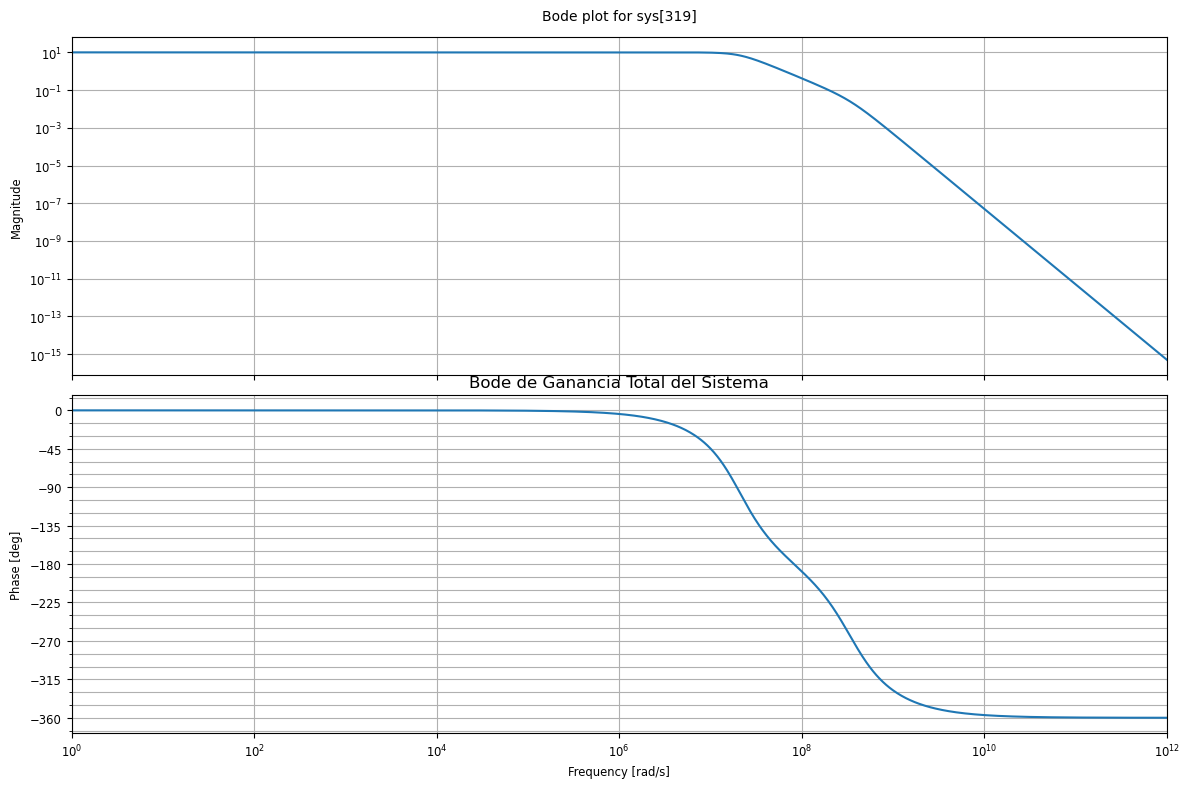

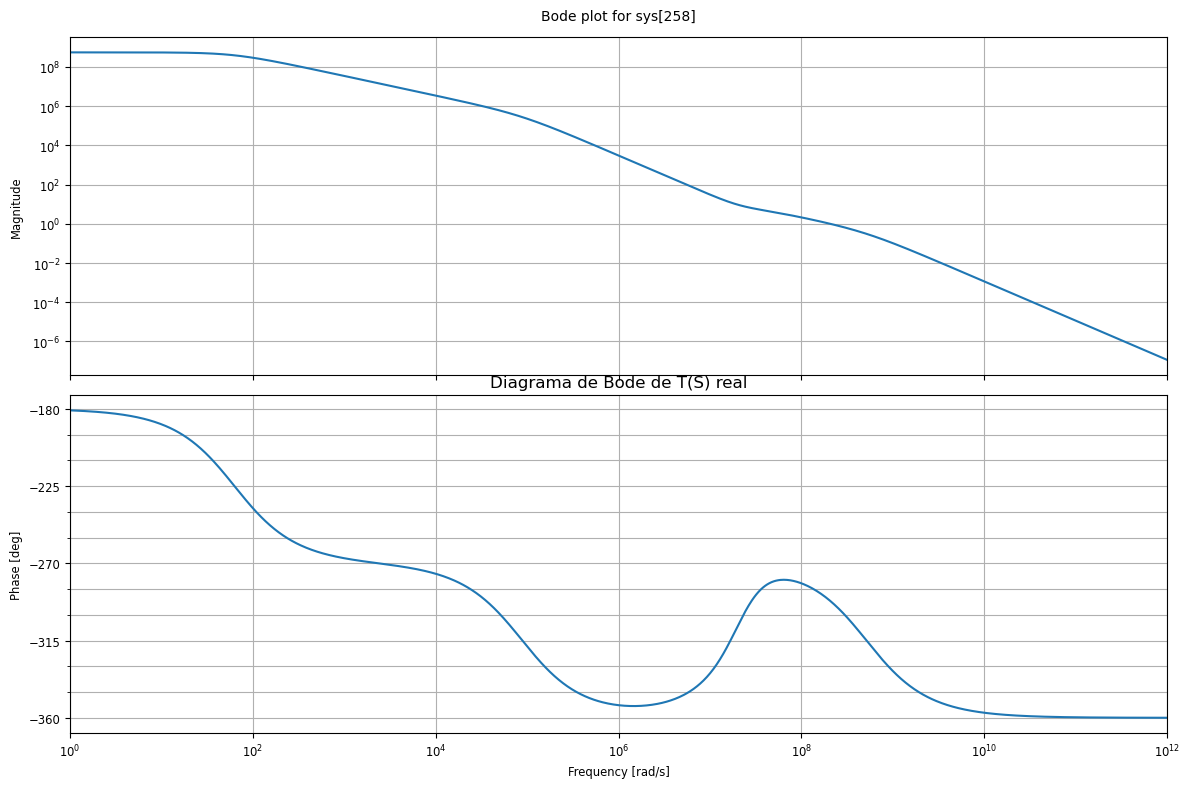

In [5]:
%pip install control numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from control import tf, bode_plot, frequency_response, mag2db
from control import step_response, impulse_response

# Definición de 's'
s = tf('s')

# Parámetros principales
R1 = 45
R2 = 925

# Término T1 (complejo, con muchos polos)
T1 = -(
    (0.1 * (1/R1 + 1/R2) * 2.37e11) +
    (1/R2) * 2.37e6 * (1 + s/(2*np.pi*10)) * (1 + s/(2*np.pi*5060000))
) / (
    (1 + s/(2*np.pi*10)) *
    (1 + s/(2*np.pi*5060000)) *
    (1 + s/(2*np.pi*14000)) *
    (1 + s/(2*np.pi*82300000))
)

# Término T2 (simplificado)
T2 = -(
    0.1 * (1 + R2/R1) * 1e5
) / (
    (1 + s/(2*np.pi*10)) *
    (1 + s/(2*np.pi*5060000)) *
    (1 + s * R2 * 4.8e-12)
)

# Ganancias abiertas A1 y A2
A1 = (
    (1/R1 + 1/R2) * 2.37e11
) / (
    (1 + s/(2*np.pi*10)) *
    (1 + s/(2*np.pi*5060000)) *
    (1 + s/(2*np.pi*14000)) *
    (1 + s/(2*np.pi*82300000))
)

A2 = (
    (1 + R2/R1) * 1e5
) / (
    (1 + s/(2*np.pi*10)) *
    (1 + s/(2*np.pi*5060000)) *
    (1 + s * R2 * 4.8e-12)
)

# Modelos cerrados
Avf1 = A1 / (1 - T1)   # Modelo completo
Avf2 = A2 / (1 - T2)   # Modelo simplificado

# -----------------------------------------------------------------
# Parte compensada con red pasiva (R1P, R2P, P)
R1P = 23
R2P = 925

P = (1 + s/(2*np.pi*5060000)) / (2 * (1 + s/(2*np.pi*10120000)))


T1P = -P * (
    0.1 * (1/R1P + 1/R2P) * 2.37e11
) / (
    (1 + s/(2*np.pi*10)) *
    (1 + s/(2*np.pi*5060000)) *
    (1 + s/(2*np.pi*14000)) *
    (1 + s/(2*np.pi*82300000))
) - (
    (1/R2P) * 2.37e6
) / (
    (1 + s/(2*np.pi*14000)) *
    (1 + s/(2*np.pi*82300000))
)

T2P = -P * (
    0.1 * (1 + R2P/R1P) * 1e5
) / (
    (1 + s/(2*np.pi*10)) *
    (1 + s/(2*np.pi*5060000)) *
    (1 + s * R2P * 4.8e-12)
)

A1P = P * (
    (1/R1P + 1/R2P) * 2.37e11
) / (
    (1 + s/(2*np.pi*10)) *
    (1 + s/(2*np.pi*5060000)) *
    (1 + s/(2*np.pi*14000)) *
    (1 + s/(2*np.pi*82300000))
)

A2P = P * (
    (1 + R2P/R1P) * 1e5
) / (
    (1 + s/(2*np.pi*10)) *
    (1 + s/(2*np.pi*5060000)) *
    (1 + s * R2P * 4.8e-12)
)
Avf1p = A1P / (1 - T1P)

# -----------------------------------------------------------------
# Análisis de Bode para T2
frecuencias = np.logspace(np.log10(1e6), np.log10(1e8), 1000)

response = frequency_response(T2, omega=frecuencias)

mag = np.squeeze(response.magnitude)
phase_rad = np.squeeze(response.phase)
omega = response.omega

dB = mag2db(mag)
phi_deg = np.degrees(phase_rad)

# Encontrar puntos de interés de forma robusta
# Más cercano a 0 dB
idx_dB = np.argmin(np.abs(dB - 0))
wg = omega[idx_dB]
phig = phi_deg[idx_dB]

# Más cercano a 65° (o el primero <=65 si preferís el comportamiento original)
idx_phi = np.argmin(np.abs(phi_deg - 65))
w_phi = omega[idx_phi]

print(f"Frecuencia más cercana a 0 dB en T2: {wg/1e6:.2f} Mrad/s  → {dB[idx_dB]:.2f} dB, fase {phig:.1f}°")
print(f"Frecuencia más cercana a 65° en T2:  {w_phi/1e6:.2f} Mrad/s  → {phi_deg[idx_phi]:.1f}°")

# gráfico de Bode solo de T2
plt.figure(figsize=(12, 8))
bode_plot(T2, omega_limits=[1e0, 1e12], label='T(S) simplificado')
plt.grid(True)
plt.title('Diagrama de Bode de T(S) simplificado')
plt.show()

plt.figure(figsize=(12, 8))
bode_plot(Avf1, omega_limits=[1e0, 1e12], label='Avf real')
plt.grid(True)
plt.title('Bode de Ganancia Total del Sistema')
plt.show()

plt.figure(figsize=(12, 8))
bode_plot(T1, omega_limits=[1e0, 1e12], label='T(S) real')
plt.grid(True)
plt.title('Diagrama de Bode de T(S) real')
plt.show()



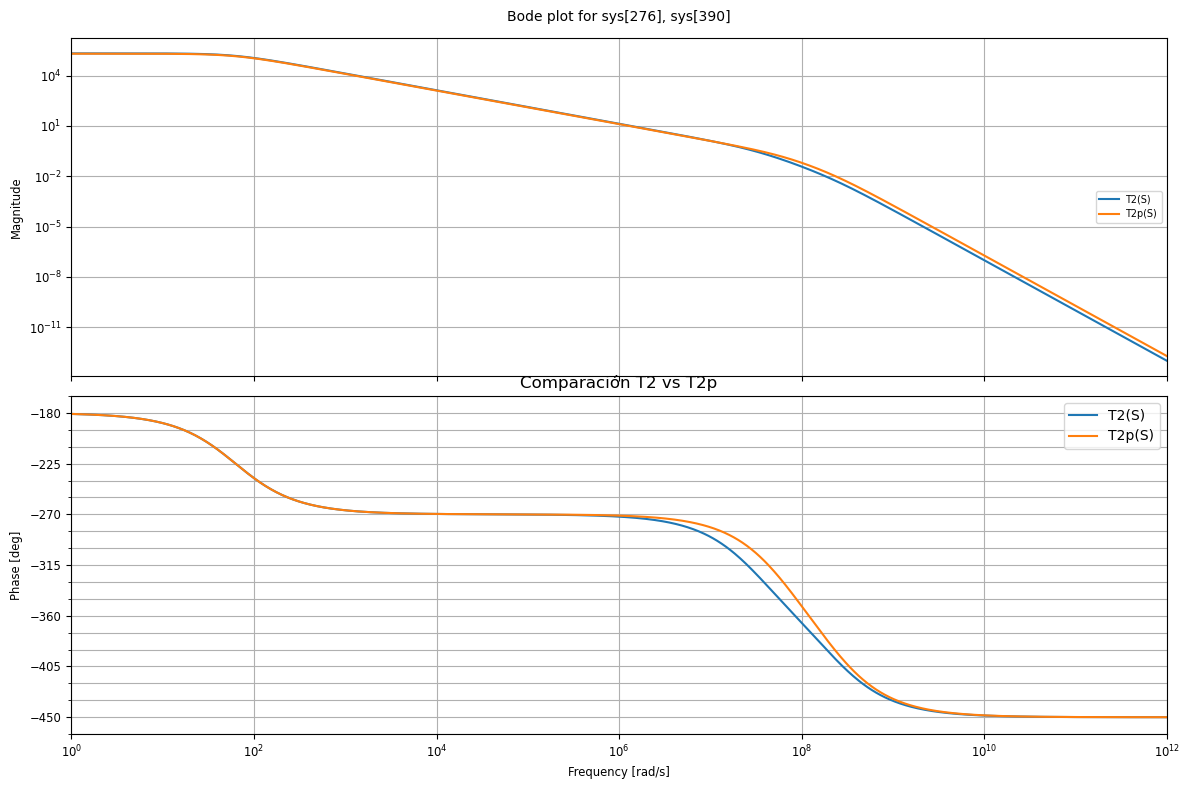

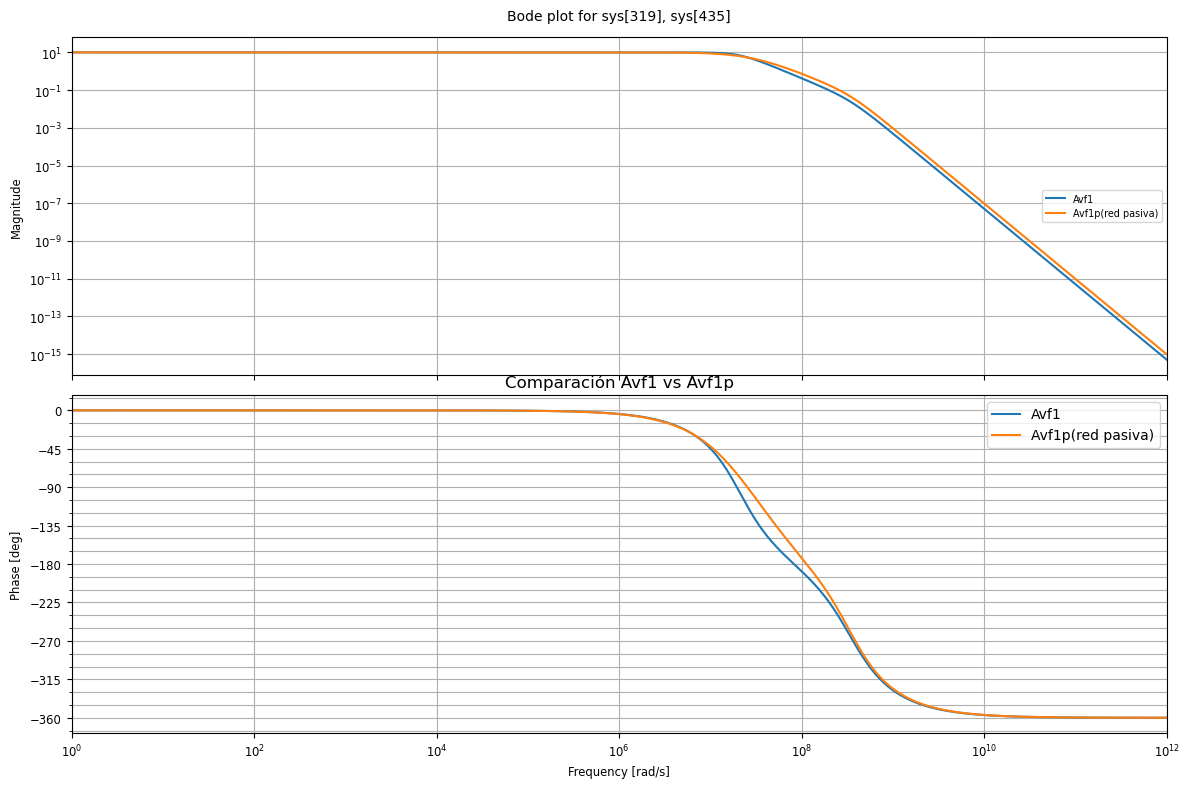

In [6]:
#comparar Avf1 vs Avf2

plt.figure(figsize=(12, 8))
bode_plot(T2,omega_limits=[1e0, 1e12], label='T2(S)')
bode_plot(T2P,omega_limits=[1e0, 1e12], label='T2p(S)')
plt.grid(True)
plt.legend()
plt.title('Comparación T2 vs T2p')
plt.show()


plt.figure(figsize=(12, 8))
bode_plot(Avf1,omega_limits=[1e0, 1e12], label='Avf1')
bode_plot(Avf1p,omega_limits=[1e0, 1e12], label='Avf1p(red pasiva)')
plt.grid(True)
plt.legend()
plt.title('Comparación Avf1 vs Avf1p')
plt.show()

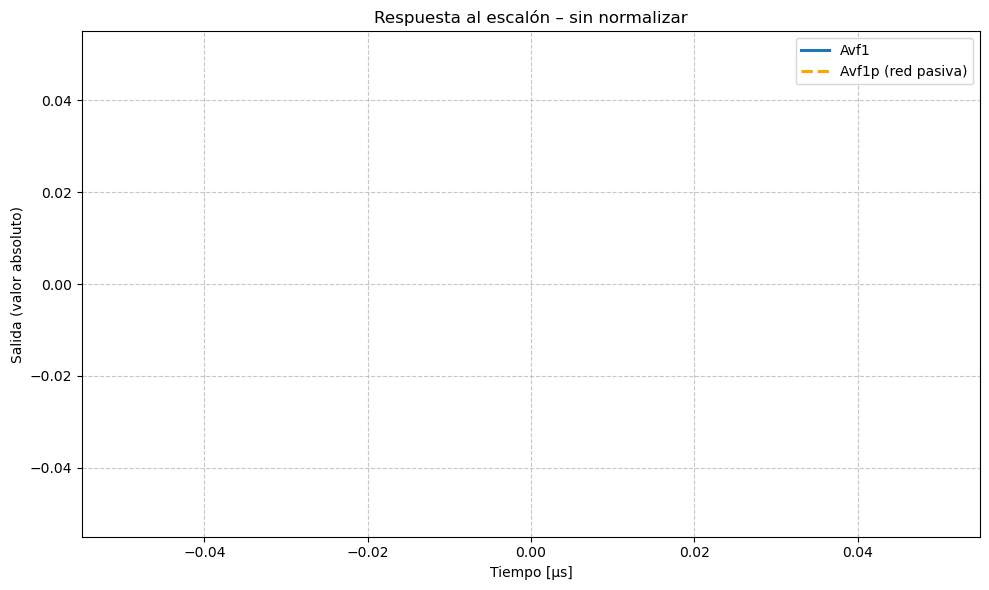

In [11]:
# Respuesta al escalón unitario de Avf1 y Avf1p
# -----------------------------------------------------------------
# Ajusta el tiempo según la dinámica del sistema 
t_max = 100e-6          # 100 µs → prueba con 200e-6 o 500e-6 si es más lento
n_points = 3000
T_sim = np.linspace(0, t_max, n_points)

# Calculamos las respuestas
t1, y1 = step_response(Avf1, T=T_sim)
t2, y2 = step_response(Avf1p, T=T_sim)

plt.figure(figsize=(10, 6))

plt.plot(t1 * 1, y1, label='Avf1', linewidth=2.2)
plt.plot(t2 * 1, y2, label='Avf1p (red pasiva)', linewidth=2.2, linestyle='--', color='orange')

plt.xlabel('Tiempo [µs]')
plt.ylabel('Salida (valor absoluto)')
plt.title('Respuesta al escalón – sin normalizar')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(loc='best')
plt.tight_layout()
plt.show()